<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S15/EVA4_S15_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")

## Mount and Fetch Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import zipfile

path_to_zip_file = "/content/gdrive/My Drive/EVA4-Workspace/persons_fg/dataset.zip"
directory_to_extract_to = '/content/'
print("Extracting zip file: %s" % path_to_zip_file)
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  for f in zip_ref.namelist():
    if f.startswith(('bg/','fg_bg/','fg_bg_masks/','fg_bg_depth/')):
      zip_ref.extract(f, directory_to_extract_to)
print("Extracted at: %s" % directory_to_extract_to)

Extracting zip file: /content/gdrive/My Drive/EVA4-Workspace/persons_fg/dataset.zip
Extracted at: /content/


## Imports and Initialization

Import required modules

In [4]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-aa1e5814-f1ad-bde3-e058-0d39c77dbcbc)


In [0]:
!rm -rf images
!mkdir images

In [2]:
!cd models;rm *.pth

rm: cannot remove '*.pth': No such file or directory


In [0]:
# !pip install albumentations==0.4.5
# !pip install kornia

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from data.data_engine import DataEngine
from config import ModelConfig
from models.depth_and_mask_dnn import DNN
from train import train
from test import test
from results import plot_images, plot_graph
from utils import *

## Model Configuration and Set Seed

View model configuration and set the seed

In [2]:
# View model config
args = ModelConfig()
args.print_config()
print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 16,
  'data_path': '/content/',
  'dropout': 0.2,
  'epochs': 3,
  'im_size': 224,
  'l1_decay': 0,
  'l2_decay': 0.0001,
  'lr': 0.0001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


## Data Loading and Visualization

Preprocess, load and visualise the dataset.

Dimensions:
bg         : [3, 224, 224]
fg_bg      : [3, 224, 224]
fg_bg_mask : [1, 224, 224]
fg_bg_depth: [1, 224, 224] 



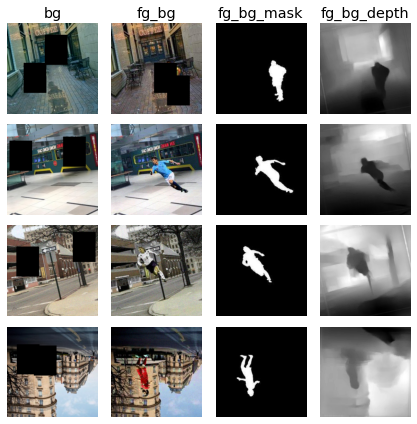

In [5]:
data = DataEngine(args)
data.show_samples()

## Model

Create model and display model summary

In [3]:
device = which_device()
model = DNN(args.dropout).to(device)
show_model_summary(model, (6,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
            Conv2d-3         [-1, 32, 224, 224]           9,216
       BatchNorm2d-4         [-1, 32, 224, 224]              64
            Conv2d-5         [-1, 32, 224, 224]           9,216
       BatchNorm2d-6         [-1, 32, 224, 224]              64
        BasicBlock-7         [-1, 32, 224, 224]               0
            Conv2d-8         [-1, 32, 224, 224]           9,216
       BatchNorm2d-9         [-1, 32, 224, 224]              64
           Conv2d-10         [-1, 32, 224, 224]           9,216
      BatchNorm2d-11         [-1, 32, 224, 224]              64
       BasicBlock-12         [-1, 32, 224, 224]               0
           Conv2d-13         [-1, 32, 224, 224]             864
      BatchNorm2d-14         [-1, 32, 2

### Load Model



Model is first trained on smaller dimensions to reduce the training time on larger dimensions
  * 64x64 | 128x128 | 224x224 

For large dimensions, since per epoch time is very high, we keep training for a small chunk of epochs, save the model, load it and train again.




In [7]:
model_path = "/content/models/saved_models/im128_l0.1473_rms0.0666_t0.8726.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Training and Testing

Train the model and evaluate it

In [4]:
import datetime

epochs = args.epochs
optimizer = torch.optim.Adam( model.parameters(), args.lr )
scheduler = StepLR(optimizer, step_size=1, gamma=0.3)

test_losses, train_losses = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(0, epochs):
    st = datetime.datetime.now()
    lr_trend.append(optimizer.param_groups[0]['lr'])
    print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
    train(model, device, data.train_loader, optimizer, epoch,
          l1_decay,l2_decay, train_losses)
    et_train = datetime.datetime.now()
    delta_train = et_train-st
    # scheduler.step()
    st_test = datetime.datetime.now()
    test(model, device, data.test_loader, test_losses, epoch, save_img=True)
    et = datetime.datetime.now()
    delta = et-st
    delta_test = et-st_test
    print(f"EPOCH: {epoch+1} processing time: {delta} [Train: {delta_train}] [Test: {delta_test}]")

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

0%|          | 0/20000 [00:00<?, ?it/s]EPOCH: 1 (LR: 0.000100)
L2_loss=342.097 Loss=0.20553 LossMask=0.03440[(d0.010,s0.018,e0.007)] LossDepth=0.136912[(s0.056,e0.010,d0.071)] Batch_id=19999: 100%|██████████| 20000/20000 [2:26:58<00:00,  2.27it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]Test set: Average loss: 0.1605, Average MaskLoss: 0.0248, Average DepthLoss: 0.1357

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Mask  :     0.9916,     0.9940,     0.9956,     0.0393
Depth :     0.6981,     0.8866,     0.9549,     0.1081
Avg   :     0.8448,     0.9403,     0.9752,     0.0737

EPOCH: 1 processing time: 2:38:56.151859 [Train: 2:26:58.901408] [Test: 0:11:57.250357]
EPOCH: 2 (LR: 0.000100)
L2_loss=322.863 Loss=0.20279 LossMask=0.03107[(d0.010,s0.015,e0.006)] LossDepth=0.139436[(s0.058,e0.010,d0.071)] Batch_id=19999: 100%|██████████| 20000/20000 [2:27:19<00:00,  2.26it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]Test set: Average loss: 0.1485, Average MaskLoss: 0.0239, Average D

## Plot Learning Rate Schedule

Plot the change in learning rate vs epochs

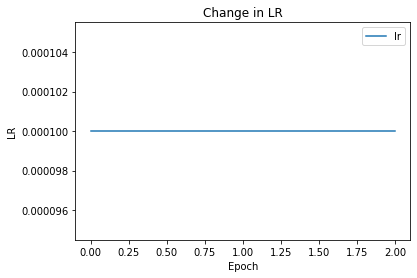

In [12]:
plt_data = {
    "lr": lr_trend,
}
plot_graph(plt_data, "LR")

## Plot Validation Loss

Plot the change in validation loss vs epochs

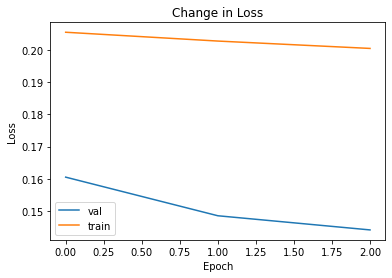

In [15]:
plt_data = {
    "val": test_losses,
    "train": train_losses,
}
plot_graph(plt_data, "Loss")

## Results & Analysis

Utils to analyse and visualise the results
- Load the saved model for a given input dimension
- Compute the metrics on validation data
  - **t<1.25, t<1.25^2 and t<1.25^3** : higher means better
  - **rms**: lower means better

In [0]:
def results_analysis(im_size, batch_size, model_path, im_fname, N=16, figsize=(9,25)):
  # coloumn titles for the plot
  titles=("bg", "fg_bg", "fg_bg_mask","fg_bg_depth","mask_pred","depth_pred")
  args.im_size = im_size
  args.batch_size_cuda = batch_size
  # load data with new args
  data = DataEngine(args)
  # load model weights
  model.load_state_dict(torch.load(model_path))
  # fetch sample validation data
  sample = next(iter(data.test_loader))
  bg = sample["bg"][:N,:,:,:]
  fg_bg = sample["fg_bg"][:N,:,:,:]
  fg_bg_mask = sample["fg_bg_mask"][:N,:,:,:].to(device)
  fg_bg_depth = sample["fg_bg_depth"][:N,:,:,:].to(device)
  inp = torch.cat([bg,fg_bg], dim=1)
  inp = inp.to(device)
  mask_pred, depth_pred = model(inp)
  print("Dimensions:")
  print("bg         :", list(bg.shape)[1:])
  print("fg_bg      :", list(fg_bg.shape)[1:])
  print("fg_bg_mask :", list(fg_bg_mask.shape)[1:])
  print("fg_bg_depth:", list(fg_bg_depth.shape)[1:])
  print("mask_pred  :", list(mask_pred.shape)[1:])
  print("depth_pred :", list(depth_pred.shape)[1:],"\n")
  # compute the metrics on validation data
  test(model, device, data.test_loader, test_losses=[], epoch=0, save_img=False)
  # prepare images to plot
  model.eval()
  images = []
  for i in range(N):
    images.extend([bg[i].detach().cpu(), fg_bg[i].detach().cpu(),
                  fg_bg_mask[i].detach().cpu(), fg_bg_depth[i].detach().cpu(),
                  mask_pred[i].detach().cpu(), depth_pred[i].detach().cpu()])
  # visualise the predictions on validation data
  show_images(images, cols=N, titles=titles, figsize=figsize, show=True, fname=im_fname, tmax=len(images))

### 64x64

Dimensions:
bg         : [3, 64, 64]
fg_bg      : [3, 64, 64]
fg_bg_mask : [1, 64, 64]
fg_bg_depth: [1, 64, 64]
mask_pred  : [1, 64, 64]
depth_pred : [1, 64, 64] 

Test set: Average loss: 0.1857, Average MaskLoss: 0.0411, Average Depthloss: 0.1445

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Mask  :     0.9808,     0.9866,     0.9900,     0.0604
Depth :     0.7569,     0.9244,     0.9743,     0.0909
Avg   :     0.8688,     0.9555,     0.9822,     0.0757



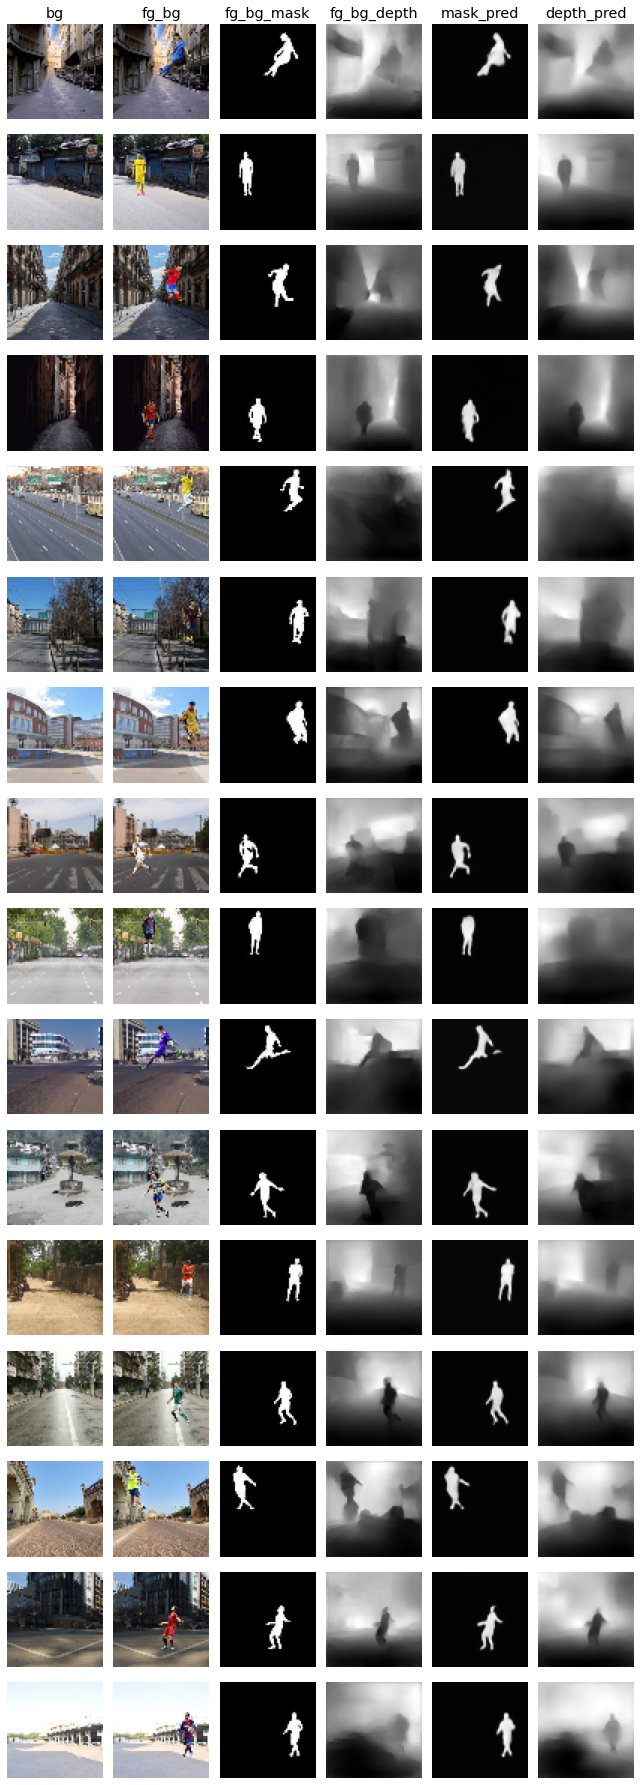

In [5]:
im_size = 64
batch_size = 64
im_fname = f"viz_im{im_size}.jpg"
model_path = "/content/models/saved_models/im64_l0.1863_rms0.0760_t0.8684.pth"
results_analysis(im_size, batch_size, model_path, im_fname, N=16, figsize=(9,25))

### 128x128

Dimensions:
bg         : [3, 128, 128]
fg_bg      : [3, 128, 128]
fg_bg_mask : [1, 128, 128]
fg_bg_depth: [1, 128, 128]
mask_pred  : [1, 128, 128]
depth_pred : [1, 128, 128] 

Test set: Average loss: 0.1474, Average MaskLoss: 0.0253, Average Depthloss: 0.1221

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Mask  :     0.9891,     0.9925,     0.9947,     0.0409
Depth :     0.7558,     0.9205,     0.9722,     0.0926
Avg   :     0.8725,     0.9565,     0.9834,     0.0667



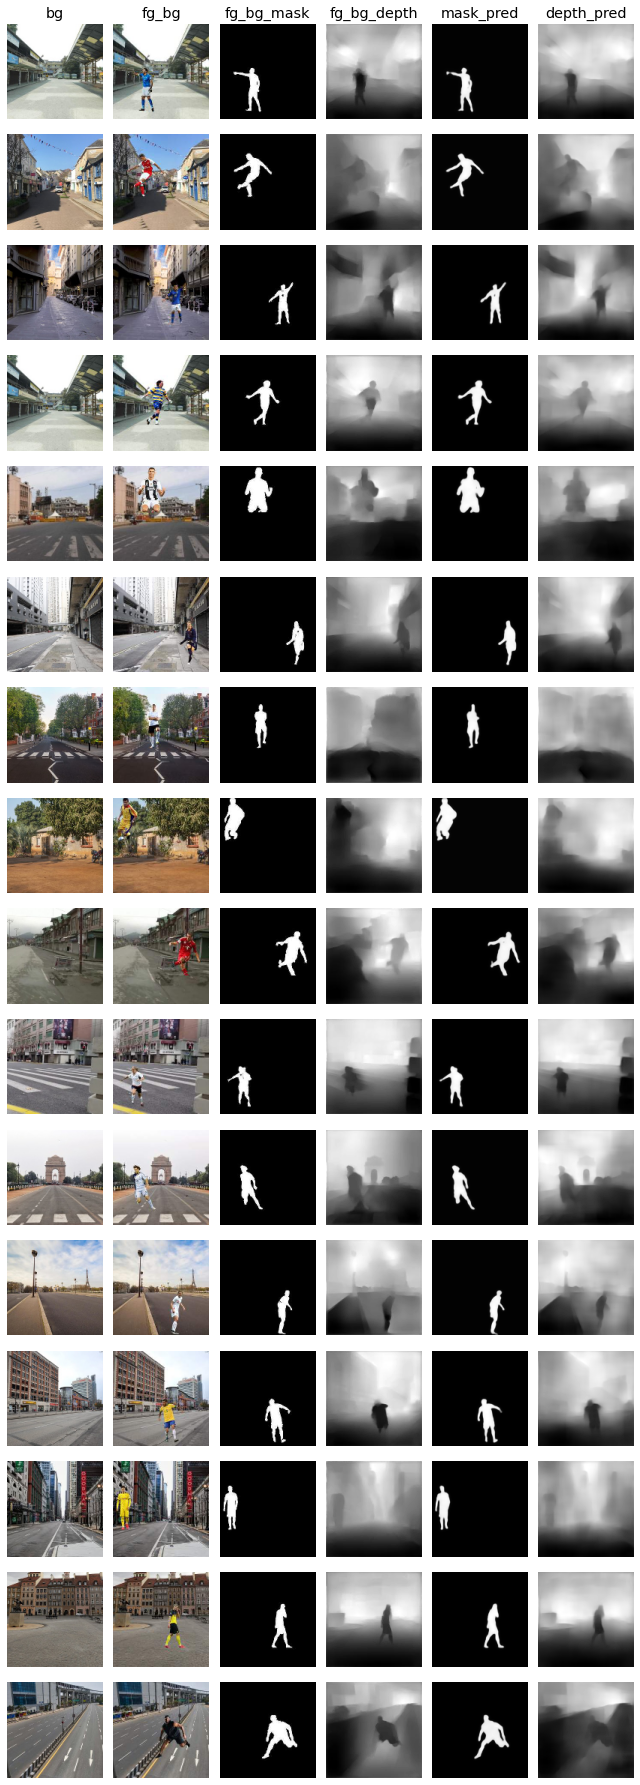

In [6]:
im_size = 128
batch_size = 64
im_fname = f"viz_im{im_size}.jpg"
model_path = "/content/models/saved_models/im128_l0.1473_rms0.0666_t0.8726.pth"
results_analysis(im_size, batch_size, model_path, im_fname, N=16, figsize=(9,25))

### 224x224

Dimensions:
bg         : [3, 224, 224]
fg_bg      : [3, 224, 224]
fg_bg_mask : [1, 224, 224]
fg_bg_depth: [1, 224, 224]
mask_pred  : [1, 224, 224]
depth_pred : [1, 224, 224] 

Test set: Average loss: 0.1446, Average MaskLoss: 0.0231, Average Depthloss: 0.1214

Metric:     t<1.25,   t<1.25^2,   t<1.25^3,        rms
Mask  :     0.9923,     0.9946,     0.9961,     0.0350
Depth :     0.7280,     0.9028,     0.9623,     0.1015
Avg   :     0.8601,     0.9487,     0.9792,     0.0682



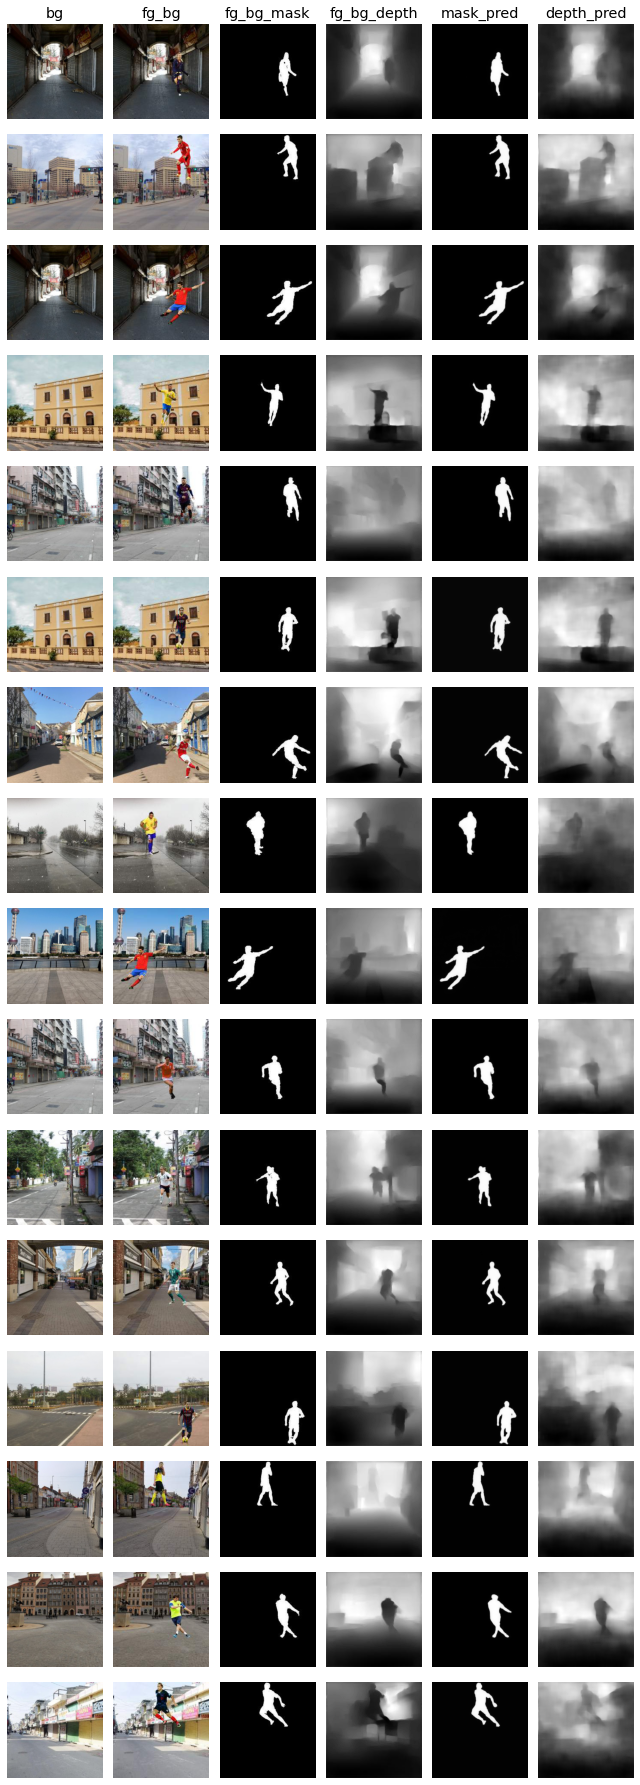

In [7]:
im_size = 224
batch_size = 16
im_fname = f"viz_im{im_size}.jpg"
model_path = "/content/models/saved_models/im224_l0.1444_rms0.0682_t0.8593.pth"
results_analysis(im_size, batch_size, model_path, im_fname, N=16, figsize=(9,25))